In [514]:
import cv2
import numpy as np
import time
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
import pandas as pd
from scipy.ndimage import label
import sys
import collections
from scipy.spatial import distance as dist
from collections import OrderedDict
from scipy.ndimage import gaussian_filter
import time
import math
import matplotlib.pyplot as plt
import os

from predict_dataset import predict_dataset

## Predicting DIC-C2DH-HeLa and creating 8-bit thresholded binary masks

In [519]:
def convert_mask(img_path):
    img16 = cv2.imread(img_path,-1)
    ratio = np.amax(img16) / 256
    img8 = (img16 / ratio).astype('uint8')
    thres = cv2.adaptiveThreshold(img8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,3,2)
    background = img8 == 0
    thres[background] = 0
    return cv2.cvtColor(thres, cv2.COLOR_GRAY2RGB)

In [557]:
DIC_path = r'../images/DIC-C2DH-HeLa/'

sequences = [3, 4]

# for seq in sequences:
#     predict_dataset(sequence=seq)

for seq in sequences:
    seq_name = 'Sequence '+str(seq)+' Masks'
    seq_name_binary = seq_name+'_binary'
    if not os.path.isdir(os.path.join(DIC_path, seq_name_binary)):
        os.mkdir(os.path.join(DIC_path, seq_name_binary))
    path = os.path.join(DIC_path, seq_name)
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in os.listdir(dirpath):
            if 'mask' in filename and '.tif' in filename:
                src = dirpath
                dest = src.replace('Masks', 'Masks_binary')
                dest_img = os.path.join(dest, filename)
                thres = convert_mask(os.path.join(src, filename))
                cv2.imwrite(os.path.join(dest, filename), thres)

In [304]:
def make_boxes(color_img,image,labels):       
    conts=[]    
    contours=[]
    centers = []
    radiuses = {}
    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0:
            continue
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(image.shape, dtype="uint8")
        mask[labels == label] = 255
        # detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_NONE)[-2]
        
        for i in range(len(cnts)):
            if len(cnts[i]) >= 5 and cv2.contourArea(cnts[i]) >= 4:
                print(cv2.contourArea(cnts[i]))
                ellipse=cv2.fitEllipse(cnts[i])
                (x, y), (MA, ma), angle=ellipse
                center = (int(x), int(y))
                centers.append(center)
                radiuses[center] = ma
                #cv2.drawContours(thresh,contours,-1,(150,10,255),3)
                #cv2.drawContours(thresh,contours,-1,(150,10,255),3)
                
                cv2.drawContours(color_img, cnts, -1, (255,0,0), 2, 1)
                cv2.drawContours(image, cnts, -1, (128,128,128), 2, 1)
                contours.append(ellipse)

    ################################################################################

    return image,color_img,radiuses,centers
def remove_background(image,back_img):
    h,w = image.shape
    output = np.zeros((h,w),dtype = "uint8")
    output = np.subtract(image,back_img)
    return output
def apply_watershed(img):
    img_array = img.copy()
    distance = ndi.distance_transform_edt(img_array)
    markers = ndi.label(peak_local_max(distance, min_distance = 10,footprint = np.ones((11, 11)), indices = False, labels = img_array))[0]
    ws_labels = watershed(-distance, markers, mask = img_array)
    print("[INFO] {} unique segments found".format(len(np.unique(ws_labels)) - 1))
    return ws_labels,markers
def segmentation_try_1(frame,gray):
        image = frame.copy()
        #applying min_max filtering
        #frame = run_algo(gray, filter_size,M)
        kernel_erosion = np.ones((3,3),np.uint8)
        erosion = cv2.erode(gray,kernel_erosion,iterations = 1)
        kernel_dilation = np.ones((5,5), np.uint8)
        img_dilation = cv2.dilate(erosion, kernel_dilation, iterations=1)
        th = cv2.adaptiveThreshold(img_dilation,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
        frame = remove_background(th,img_dilation)
        blur = cv2.GaussianBlur(frame,(5,5),0)
        ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        frame = cv2.bitwise_not(th)
        
        kernel_erosion = np.ones((2,2),np.uint8)
        frame = cv2.erode(frame,kernel_erosion,iterations = 4)
        
        #frame = frst(frame,2,2,0.25,0.25)
        label,markers = cv2.connectedComponents(frame)
       # print("labels",label)
       # print("markers",markers)
        #pd.DataFrame(markers).to_csv("markers.csv")
        #pd.DataFrame(label).to_csv("labels.csv")
        frame_boxes,color_img,radiuses,centers = make_boxes(image,frame,markers)
#         return image,frame,markers
        return color_img,frame_boxes,markers,radiuses,centers

In [5]:
def segmentation_try_3(frame):
        image = frame.copy()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
                
        filtersize = (5,5)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filtersize)
        frame = cv2.erode(frame, kernel, iterations=1)
        
        filtersize = (3,3)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filtersize)


        th = cv2.morphologyEx(frame,cv2.MORPH_TOPHAT,kernel)

        
        thresh = cv2.adaptiveThreshold(th,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
        
        
        gf = gaussian_filter(th,3)
        
        sub = cv2.subtract(gf,3)
        frame = cv2.dilate(sub, kernel, iterations=1)

        frame_thresh = np.where(frame < 1,sub,255)
        

        return frame_thresh

In [6]:
class CentroidTracker():
    def __init__(self, cellID, maxDisappeared=10):
        # initialize the next unique object ID along with two ordered
        # dictionaries used to keep track of mapping a given object
        # ID to its centroid and number of consecutive frames it has
        # been marked as "disappeared", respectively
        self.nextObjectID = 1
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        
        self.colors = OrderedDict()
        self.coords = OrderedDict()
        self.info = OrderedDict()
        self.selCell = cellID;

        # store the number of maximum consecutive frames a given
        # object is allowed to be marked as "disappeared" until we
        # need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared

    def register(self, centroid):
        
        # when registering an object we use the next available object
        # ID to store the centroid
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        
        self.colors[self.nextObjectID] = tuple(np.random.choice(range(256), size=3))
        
        coord_list = list()
        coord_list.append(centroid)
        self.coords[self.nextObjectID] = coord_list
        
        cell_info = {'speed': 0.0, 'tDist': 0.0, 'nDist': 0.0, 'ratio': 0.0}
        self.info[self.nextObjectID] = cell_info
        
        self.nextObjectID += 1
        
    def deregister(self, objectID):
        # to deregister an object ID we delete the object ID from
        # both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]
        del self.colors[objectID]
        del self.coords[objectID]
        del self.info[objectID]

    def update(self, inputCentroids):
        # check to see if the list of input bounding box rectangles
        # is empty
        if len(inputCentroids) == 0:
            # loop over any existing tracked objects and mark them
            # as disappeared
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1

                # if we have reached a maximum number of consecutive
                # frames where a given object has been marked as
                # missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)

            # return early as there are no centroids or tracking info
            # to update
            return self.objects

        # initialize an array of input centroids for the current frame
        #inputCentroids = np.zeros((len(rects), 2), dtype="int")

        # loop over the bounding box rectangles
#         for (i, (startX, startY, endX, endY)) in enumerate(rects):
#             # use the bounding box coordinates to derive the centroid
#             cX = int((startX + endX) / 2.0)
#             cY = int((startY + endY) / 2.0)
#             inputCentroids[i] = (cX, cY)

        # if we are currently not tracking any objects take the input
        # centroids and register each of them
        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i])
        # otherwise, are are currently tracking objects so we need to
        # try to match the input centroids to existing object
        # centroids
        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())

            # compute the distance between each pair of object
            # centroids and input centroids, respectively -- our
            # goal will be to match an input centroid to an existing
            # object centroid
            D = dist.cdist(np.array(objectCentroids), inputCentroids)

            # in order to perform this matching we must (1) find the
            # smallest value in each row and then (2) sort the row
            # indexes based on their minimum values so that the row
            # with the smallest value as at the *front* of the index
            # list
            rows = D.min(axis=1).argsort()

            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]

            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()

            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
                if row in usedRows or col in usedCols:
                    continue

                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
                objectID = objectIDs[row]
                
     ###############Task 3           
                # calculate distance between previous and current
                # coords and update cell info
                path_dist = cv2.norm(np.subtract(self.objects[objectID], inputCentroids[col]))
                norm_dist = cv2.norm(np.subtract(self.coords[objectID][0], inputCentroids[col]))
                self.info[objectID]['speed'] = path_dist
                self.info[objectID]['tDist'] += path_dist
                self.info[objectID]['nDist'] = norm_dist
                if (norm_dist != 0):
                    self.info[objectID]['ratio'] = self.info[objectID]['tDist']/norm_dist
    ###############         
                
                self.objects[objectID] = inputCentroids[col]
                self.coords[objectID].append(inputCentroids[col])
                self.disappeared[objectID] = 0

                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)

            # compute both the row and column index we have NOT yet
            # examined
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)

            # in the event that the number of object centroids is
            # equal or greater than the number of input centroids
            # we need to check and see if some of these objects have
            # potentially disappeared
            if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
                for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1

                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)

            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input centroid as a trackable object
            else:
                for col in unusedCols:
                    self.register(inputCentroids[col])
        
        #######task 3
        if self.selCell != "0":
            index = int(self.selCell)
            if index < len(self.info):
                info = "\nCell ID {}\n speed: {}\n tDist: {}\n nDist: {}\n ratio: {}\n".format(index, self.info[index]['speed'], self.info[index]['tDist'],self.info[index]['nDist'],self.info[index]['ratio'])           
                print(info)
        ######
        # return the set of trackable objects
        return self.objects
    
    def get_color(self, objectID):
        return self.colors[objectID]
    def get_coord(self, objectID):
        return self.coords[objectID]

In [7]:
def draw_line(image, coord1, coord2, color):
    cv2.line(image, (int(coord1[0]), int(coord1[1])), (int(coord2[0]), int(coord2[1])) , color)

In [8]:
def mitosis_detection(Black,segmentation_try_1_img,inputCentroids,radiuses):
    kernel = np.ones((2,2),np.uint8)
    tmp = cv2.erode(Black, kernel, iterations = 2)
    dividing_cells = set()

    _, tmp_contours, _ = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    tmp_centers = []

    for contour in tmp_contours:
        (x,y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        tmp_centers.append(center)




    E_distances = dist.cdist(tmp_centers, tmp_centers, metric='euclidean')
    for x in range(len(E_distances)):
        for y in range(len(E_distances)):
            if E_distances[x][y] < 20 and x != y:
                point_1 = tmp_centers[x]
                point_2 = tmp_centers[y]
                dividing_cells.add(point_1)
                dividing_cells.add(point_2)

    dividing_centers = set()
    for center in dividing_cells:
        for x in inputCentroids:
            dist1 = math.sqrt((x[0]-center[0])**2 + (x[1]-center[1])**2)
            if dist1 < radiuses[x]:
                dividing_centers.add(x)
                cv2.ellipse(segmentation_try_1_img, (int(x[0]), int(x[1])), (20,15), 0, 0, 360, (0,0,255), 2)

    

In [26]:
cap = cv2.VideoCapture(r"../images/DIC-C2DH-HeLa/Sequence 4 Masks/*.tif")

filter_size = 3
selectedCell = input("please enter cellID of cell to track, 0 if you would not like to track a cell: ")
ct = CentroidTracker(selectedCell)

while(1):
    ret, frame = cap.read()
    start_time = time.time()
    if (ret) :
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow("Frame1", frame)
#####################Section 1#########################################################      

        segmentation_try_1_img,Black,markers,radiuses,inputCentroids = segmentation_try_1(frame,gray)
        
####################Sectior 3########################################################

#         frame_thresh = segmentation_try_3(frame)
#         _, contours, _ = cv2.findContours(frame_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#         inputCentroids = []
#         for contour in contours:
#             (x,y), radius = cv2.minEnclosingCircle(contour)
#             center = (x, y)
#             inputCentroids.append(center)

##################Tracking from centroids########################################################        

    
        mitosis_detection(Black,segmentation_try_1_img,inputCentroids,radiuses)
        objects = ct.update(inputCentroids)
        for (objectID, centroid) in objects.items():
        # draw both the ID of the object and the centroid of the
        # object on the output frame
            color = (int(ct.get_color(objectID)[1]), int(ct.get_color(objectID)[0]), int(ct.get_color(objectID)[2]))

            text = "ID {}".format(objectID)
                #print(int(centroid[1]),int(centroid[0]))
            cv2.putText(segmentation_try_1_img, text, (int(centroid[0]), int(centroid[1])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            cv2.circle(segmentation_try_1_img, (int(centroid[0]), int(centroid[1])), 4, color, 1)

            for ind, coord in enumerate(ct.get_coord(objectID)):
                if ind < len(ct.get_coord(objectID)) - 1:
                    draw_line(segmentation_try_1_img, coord, ct.get_coord(objectID)[ind + 1], color)

        # show the output frame
        cv2.imshow("Frame", segmentation_try_1_img)
        end_time = time.time()
        fps = 1/(end_time - start_time)
        print("Frame Per Second: ", fps)

        time.sleep(0.5)

    else:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    # 'q' to quit playback
    if (cv2.waitKey(1) & 0xFF == ord('q')):
        break
        
cap.release()
cv2.destroyAllWindows()

please enter cellID of cell to track, 0 if you would not like to track a cell: 0


KeyboardInterrupt: 

In [549]:
def make_boxes_DIC(color_img,image,labels):       
    conts=[]    
    contours=[]
    centers = []
    radiuses = {}
    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0:
            continue
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(image.shape, dtype="uint8")
        mask[labels == label] = 255
        # detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_NONE)[-2]
        
        for i in range(len(cnts)):
            if len(cnts[i]) >= 5 and cv2.contourArea(cnts[i]) > 2500:
                print('cv2.contourArea(cnts[i])', cv2.contourArea(cnts[i]))
                ellipse=cv2.fitEllipse(cnts[i])
                (x, y), (MA, ma), angle=ellipse
                center = (int(x), int(y))
                centers.append(center)
                radiuses[center] = ma
                #cv2.drawContours(thresh,contours,-1,(150,10,255),3)
                #cv2.drawContours(thresh,contours,-1,(150,10,255),3)
                
                cv2.drawContours(color_img, cnts, -1, (255,0,0), 2, 1)
                cv2.drawContours(image, cnts, -1, (128,128,128), 2, 1)
                contours.append(ellipse)

    ################################################################################

    return image,color_img,radiuses,centers

In [550]:
def segmentation_try_1_DIC(frame, gray):
    kernel_erosion = np.ones((3,3),np.uint8)
    gray = cv2.erode(gray,kernel_erosion,iterations = 2)    
    label,markers = cv2.connectedComponents(gray)
    frame_boxes,color_img,radiuses,centers = make_boxes_DIC(frame,gray,markers)

    return color_img,frame_boxes,markers,radiuses,centers

In [551]:
img_path = r"C:\Users\tyson\Downloads\top 3\DIC-C2DH-HeLa\MU-Lux-CZ\03_RES_binary\t100mask.tif"
frame = cv2.imread(img_path)
gray = cv2.imread(img_path, -1)
# kernel_erosion = np.ones((3,3),np.uint8)
# gray = cv2.erode(gray,kernel_erosion,iterations=2)
# label,markers = cv2.connectedComponents(gray)
# frame_boxes,color_img,radiuses,centers = make_boxes_DIC(frame,gray,markers)
color_img,frame_boxes,markers,radiuses,centers = segmentation_try_1_DIC(frame, gray)

cv2.contourArea(cnts[i]) 30860.0
cv2.contourArea(cnts[i]) 18647.5
cv2.contourArea(cnts[i]) 12263.0
cv2.contourArea(cnts[i]) 35643.0
cv2.contourArea(cnts[i]) 2521.0
cv2.contourArea(cnts[i]) 13880.5
cv2.contourArea(cnts[i]) 6190.5
cv2.contourArea(cnts[i]) 4340.0
cv2.contourArea(cnts[i]) 8003.0


In [552]:
len(centers)

9

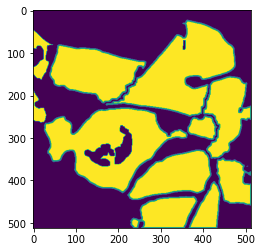

In [554]:
plt.imshow(frame_boxes)

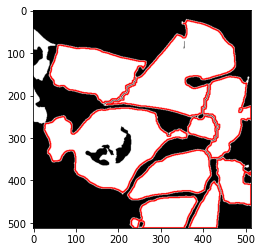

In [555]:
plt.imshow(color_img)

In [215]:
img_path = r"../images/Fluo-N2DL-HeLa/Sequence 3/t000.tif"
frame = cv2.imread(img_path)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
color_img,frame_boxes,markers,radiuses,centers = segmentation_try_1(frame, gray)
frame_boxes,color_img,radiuses,centers = make_boxes(frame,gray,markers)

394.0
109.5
438.0
215.0
483.5
466.0
230.0
403.5
247.0
193.5
241.5
521.0
166.0
229.0
234.0
44.5
142.0
248.0
540.5
271.5
27.5
248.0
466.0
240.0
21.0
76.0
205.5
161.5
513.5
217.0
100.5
574.5
501.0
329.0
338.5
276.0
394.0
109.5
438.0
215.0
483.5
466.0
230.0
403.5
247.0
193.5
241.5
521.0
166.0
229.0
234.0
44.5
142.0
248.0
540.5
271.5
27.5
248.0
466.0
240.0
21.0
76.0
205.5
161.5
513.5
217.0
100.5
574.5
501.0
329.0
338.5
276.0


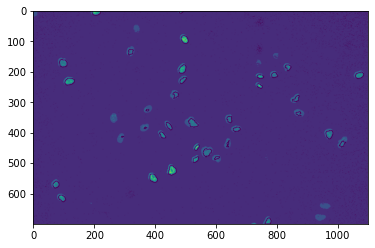

In [145]:
plt.imshow(frame_boxes)

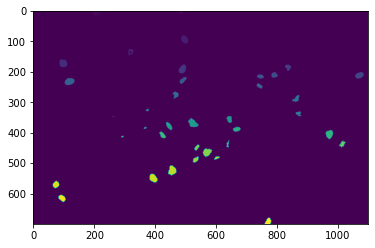

In [25]:
plt.imshow(markers)